---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 1 - Creating and Manipulating Graphs

Eight employees at a small company were asked to choose 3 movies that they would most enjoy watching for the upcoming company movie night. These choices are stored in the file `Employee_Movie_Choices.txt`.

A second file, `Employee_Relationships.txt`, has data on the relationships between different coworkers. 

The relationship score has value of `-100` (Enemies) to `+100` (Best Friends). A value of zero means the two employees haven't interacted or are indifferent.

Both files are tab delimited.

In [41]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite

# Bipartition: Two disjoint set of nodes (-> 'partition'), set1 'employees' vs. set2 'movies'

# This is the set of employees
employees = set(['Pablo',
                 'Lee',
                 'Georgia',
                 'Vincent',
                 'Andy',
                 'Frida',
                 'Joan',
                 'Claude'])

# This is the set of movies
movies = set(['The Shawshank Redemption',
              'Forrest Gump',
              'The Matrix',
              'Anaconda',
              'The Social Network',
              'The Godfather',
              'Monty Python and the Holy Grail',
              'Snakes on a Plane',
              'Kung Fu Panda',
              'The Dark Knight',
              'Mean Girls'])


# you can use the following function to plot graphs
# make sure to comment it out before submitting to the autograder
def plot_graph(G, weight_name=None, main = ''):
    '''
    G: a networkx G
    weight_name: name of the attribute for plotting edge weights (if G is weighted)
    '''
    %matplotlib notebook
    import matplotlib.pyplot as plt
    
    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = None
    
    if weight_name:
        weights = [int(G[u][v][weight_name]) for u,v in edges]
        labels = nx.get_edge_attributes(G,weight_name)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        nx.draw_networkx(G, pos, edges=edges, width=weights);
        plt.title(main)
    else:
        nx.draw_networkx(G, pos, edges=edges);
        plt.title(main)

### Question 1

Using NetworkX, load in the bipartite graph from `Employee_Movie_Choices.txt` and return that graph.

*This function should return a networkx graph with 19 nodes and 24 edges*

In [42]:
def answer_one():
    G = nx.read_edgelist('Employee_Movie_Choices.txt', delimiter="\t")   # alternatively      
    # Or from pandas...
    #G_df = pd.read_csv('Employee_Movie_Choices.txt', header=0, delimiter="\t", names=['employee', 'movie'])
    #G = nx.from_pandas_dataframe(G_df, 'employee', 'movie')
    #G.edges(data=True)   # show edge info
    return G

<IPython.core.display.Javascript object>


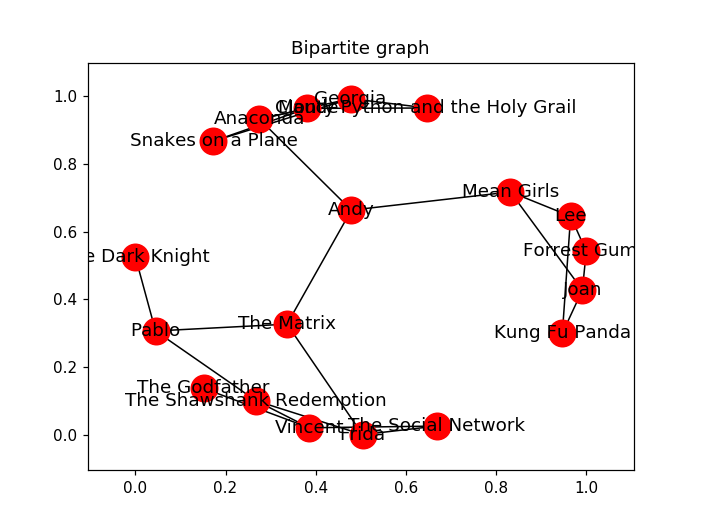

In [44]:
plot_graph(G = answer_one(), weight_name=None, main = "Bipartite graph")

### Question 2

Using the graph from the previous question, add nodes attributes named `'type'` where movies have the value `'movie'` and employees have the value `'employee'` and return that graph.

*This function should return a networkx graph with node attributes `{'type': 'movie'}` or `{'type': 'employee'}`*

In [25]:
def answer_two():
    G = answer_one()
    for node_name in G.node.keys():
        if node_name in employees:
            # Add attribute(s) to nodes:
            G.node[node_name] = {'type' : 'employee'}
            #G.add_node('node name', {'dob': 1185, 'pob': 'usa', 'dayob': 'monday'})    # alternatively
        else:
            G.node[node_name] = {'type' : 'movie'}
    #print(bipartite.is_bipartite(answer_two()))            # is graph bipartite?        
    #print(bipartite.sets(answer_two()))                # show the two disjoint sets
    return G

<IPython.core.display.Javascript object>


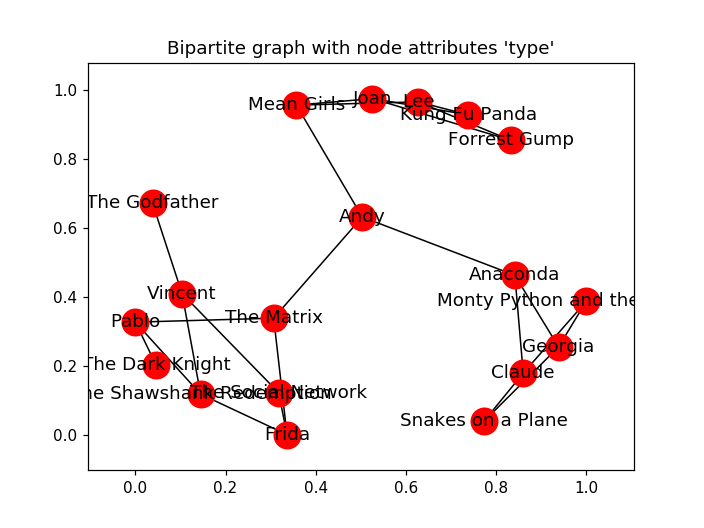

In [48]:
plot_graph(G = answer_two(), main = "Bipartite graph with node attributes 'type'")

### Question 3

Find a weighted projection of the graph from `answer_two` which tells us how many movies different pairs of employees have in common.

*This function should return a weighted projected graph.*

In [31]:
def answer_three():
    # L-bipartite graph projection: Network of nodes in set/group L, 
    # where a pair of nodes is connected if they have common neighbor in set/group R in the bipartite graph 
    # 'subgraphs' for nodes in each set L,R
    # Here: employees are connected if they at least one movie in common and the same for movies
    # Edge weights could for example be proportional to the number of neighbors (here number of movies) 
    # any two nodes in the projection 
    # have in common (in the original bipartite graph) 
    G = answer_two()
    #projG = bipartite.projected_graph(G, movies)
    wprojG = bipartite.weighted_projected_graph(G, employees)
    #print(wprojG.edges(data=True))    # print resulting projected subgraph with edge weights ('number of common employees')
    return wprojG

<IPython.core.display.Javascript object>


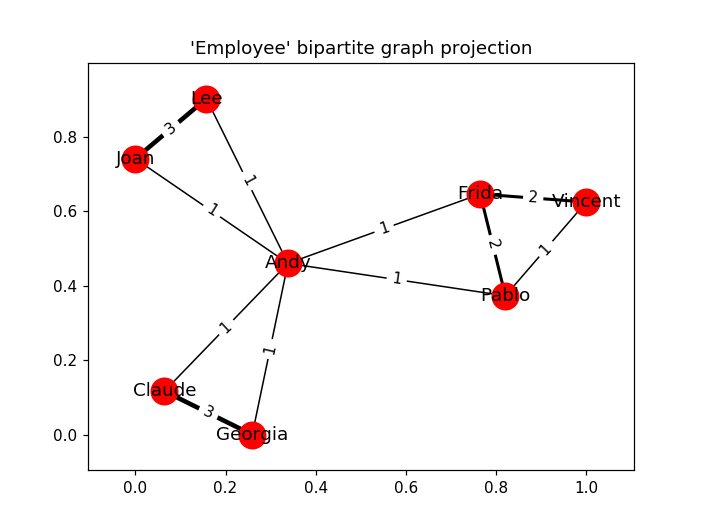

In [47]:
plot_graph(G = answer_three(), weight_name='weight', main = "'Employee' bipartite graph projection")

### Question 4

Suppose you'd like to find out if people that have a high relationship score also like the same types of movies.

Find the Pearson correlation ( using `DataFrame.corr()` ) between employee relationship scores and the number of movies they have in common. If two employees have no movies in common it should be treated as a 0, not a missing value, and should be included in the correlation calculation.

*This function should return a float.*

In [7]:
def answer_four():
        
    # Your Code Here
    G = answer_three()   # 'Employee' bipartite graph projection with number of common movies as edge weights
    Rel = nx.read_edgelist('Employee_Relationships.txt' ,data=[('relationship_score', int)])  # create weighted undirected graph, has structure of bipartite graph 
    
    G_df = pd.DataFrame(G.edges(data=True), columns=['From', 'To', 'movies_score'])
    Rel_df = pd.DataFrame(Rel.edges(data=True), columns=['From', 'To', 'relationship_score'])
    
    G_copy_df = G_df.copy()
    G_copy_df.rename(columns={"From":"From1", "To":"From"}, inplace=True)
    G_copy_df.rename(columns={"From1":"To"}, inplace=True)
    
    G_final_df = pd.concat([G_df, G_copy_df])    # cover all link directions, e.g. (A, B) and (B, A)
    
    # For correl. calculation both vectors have to have the same number of components!
    final_df = pd.merge(G_final_df, Rel_df, on = ['From', 'To'], how='right')   # rel_df is reference w.r.t to number of rows/edges
    
    final_df['movies_score'] = final_df['movies_score'].map(set_value)
    
    final_df['movies_score'] = final_df['movies_score'].map(lambda x: x['weight'])
    final_df['relationship_score'] = final_df['relationship_score'].map(lambda x: x['relationship_score'])
    
    value = final_df['movies_score'].corr(final_df['relationship_score'])
    
    return value

# Replace nonmatching tuples in merge (=NA) by zero values
def set_value(val):
    if val is np.nan:
        return {'weight': 0}
    else:
        return val